# ENVS 563 Computational Essay
In 2015, the Sustainable Cities Index ranked Toronto as the most sustainable city in North America [1]. This analysis will examine some of the contributing factors, identify how these factors impact specific demographics, and highlight areas where more could be done to improve the city's green credentials.

In [1]:
# Import required libraries

# Mathematical functions and matrix manipulation
import numpy as np

# General data handling
import pandas as pd
import geopandas as gpd

# Creating plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
# Adding basemaps to choropleths
import contextily as cx

# Creating spatial weights matrices
from pysal.lib import weights
# Calculating moran's I
import esda

# k means clustering for geodemographic classification
from sklearn import cluster
# davies bouldin score for clustering evaluation
from sklearn.metrics import davies_bouldin_score

## Data Preparation

### Dataset 1: Neighbourhood socio-economic
This dataset comprises variables aggregated across official city neighbourhoods.

In [2]:
# Read dataset from course website as a geodataframe to make use of geometry
url = 'https://darribas.org/gds_course/_downloads/a2bdb4c2a088e602c3bd6490ab1d26fa/toronto_socio-economic.gpkg'
neis = gpd.read_file(url)

#### Area

In [3]:
# Create a new area column using local projected coordinate reference system
neis['areaGeometry_km2'] = neis.to_crs('EPSG:4536').area / 1000**2
# Drop original area column due to discrepancy with calculated area
neis = neis.drop(columns = ['Shape__Area'])

#### Age

In [4]:
# Create list of all columns holding age variables to simplify handling
# As pop85+ column holds only relatively small counts and pop65+ column already includes pop85+ counts, pop85+ will not be used
ageCols = ['pop_0-14_yearsold', 'pop_15-24_yearsold', 'pop_25-54_yearsold', 'pop_55-64_yearsold', 'pop_65+_yearsold']

# Create a new total population count column
neis['popTotal'] = neis[ageCols].sum(axis=1)
# Drop original population column due to count discrepancy
neis = neis.drop(columns = ['population2016'])

# Create new aggregated groups as percentages of the total population of each neighbourhood
neis['youngPeopleRate%'] = 100 * (neis['pop_0-14_yearsold'] + neis['pop_15-24_yearsold']) / neis['popTotal']
neis['workingAgeRate%'] = 100 * (neis['pop_25-54_yearsold'] + neis['pop_55-64_yearsold']) / neis['popTotal']
neis['retirementAgeRate%'] = 100 * (neis['pop_65+_yearsold']) / neis['popTotal']

#### Population density

In [5]:
# Create population density variable from calculated total population and geometry area
neis['popDensity_km-2'] = neis['popTotal']/neis['areaGeometry_km2']
# Drop original population density column
neis = neis.drop(columns = ['population_sqkm'])
# Create natural log of population density variable due to right skewed population density distribution
neis['natLog(PopDensity_km-2)'] = np.log(neis['popDensity_km-2'])

#### Bedrooms
Mean bedroom count will be used as a proxy for property size. Properties with more than four bedrooms are regarded as having exactly four.

In [6]:
# Create list of all columns holding bedroom count variables to simplify handling
bedroomCols = ['bedrooms_0', 'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4+'] 
# Create count of properties from sum of all bedroom counts
neis['properties'] = neis[bedroomCols].sum(axis=1)

# Create mean bedroom count for each neighbourhood as weighted average
neis['meanBedroomCount'] = (0*neis['bedrooms_0'] + 1*neis['bedrooms_1'] +\
                            2*neis['bedrooms_2'] + 3*neis['bedrooms_3'] +\
                            4*neis['bedrooms_4+'])/neis['properties']

#### Employment

In [7]:
# Create employment rate using only working age population
neis['employmentRate%'] = 100 * neis['employed'] / (neis['pop_25-54_yearsold'] + neis['pop_55-64_yearsold'])

### Dataset 2: Public parks
This dataset includes geographical information for public parks and green spaces.  
https://open.toronto.ca/dataset/parks/

In [8]:
# Read dataset as a geodataframe to enable spatial manipulation
parks = gpd.read_file('envs563/parks/CITY_GREEN_SPACE_WGS84.shp')
# Remove NaN geometry row
parks = parks.iloc[parks['geometry'].dropna().index]

### Dataset 3: Tree cover
This dataset comprises geographical information on tree cover.  
https://open.toronto.ca/dataset/topographic-mapping-treed-area/

In [9]:
# Read dataset as a geodataframe to enable spatial manipulation
trees = gpd.read_file('envs563/TopographicMapping–TreedArea/TOPO_TREED_AREA_WGS84.shp')

### Green spaces
The geographical distributions of parks and tree cover are combined and used to calculate a measure of neighbourhood greenness. Although over 90% of this combined area is contributed by the parks dataset, the tree cover captures the contribution of tree lined streets and trees on private property.

In [10]:
# Create a new geodataframe from geometry of parks and trees
# There are many overlapping geometries between the two datasets as there is much tree cover within parks
# Union method is used to combine these geometries and prevent double counting
greenSpaces = gpd.GeoDataFrame({'geometry':parks['geometry'].union(trees['geometry'])})

# Create a new geodataframe by overlaying greenSpaces geometry on neighbourhood geometry
# Intersection of geometries will create a row for each green space polygon in each neighbourhood
neisGreenSpaces = gpd.overlay(neis, greenSpaces, how='intersection')

# Calculate area of each green space
neisGreenSpaces['greenSpacesArea_km2'] = neisGreenSpaces.to_crs('EPSG:4536').area / 1000**2

# Create pandas Series containing sum of green space area for each neighbourhood by grouping rows by neighbourhood id
greenSpacesArea = pd.Series(neisGreenSpaces.groupby('_id')['greenSpacesArea_km2'].sum())

# Merge calculated green space area with main neighbourhood dataset using id variable
neis = neis.merge(greenSpacesArea, on='_id')

# Calculate percentage of each neighbourhood comprising green space by dividing by neighbourhood area
neis['greenSpacesArea%'] = 100 * neis['greenSpacesArea_km2'] / neis['areaGeometry_km2']

C:\Users\sgibs\anaconda3\lib\site-packages\geopandas\base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


### Dataset 4: Walk Score ratings
Walk Score produces ratings for sustainable transport options for different locations. This analysis will use Walk Score's ratings for walking, cycling and public transport.  
https://www.walkscore.com/CA-ON/Toronto

In [11]:
# Read in data
walkscore = pd.read_csv('envs563/walkscore/walkscore.csv')

In [12]:
# A number of the neighbourhoods have slightly different names in the walkscore dataset
# Create a dictionary to map walkscore df names to neis gdf names
walkscoreMap = {'Danforth Village - East York':'Danforth East York',
              'Cabbagetown-South St.James Town':'Cabbagetown-South St. James Town',
              'Dovercourt-Wallace Emerson-Juncti':'Dovercourt-Wallace Emerson-Junction',
              'Oakwood-Vaughan':'Oakwood Village',
              'Crescent Town':'Taylor-Massey',
              'Markland Woods':'Markland Wood',
              'Danforth Village - Toronto':'Danforth',
              'Mimico':'Mimico (includes Humber Bay Shores)',
              'North St.James Town':'North St. James Town',
              'Weston-Pellam Park':'Weston-Pelham Park',
              'Corsa Italia-Davenport':'Corso Italia-Davenport',
              'Caledonia-Fairbanks':'Caledonia-Fairbank'
             }

# Replace walkscore names with neis names using mapping
walkscore = walkscore.replace(walkscoreMap)

In [13]:
# Merge walkscore ratings to main neighbourhood dataset using neighbourhood names
neis = pd.merge(neis, walkscore[['Name', 'Walk Score', 'Transit Score', 'Bike Score']],
                left_on='neighbourhood_name', 
                right_on='Name', 
                copy=False)

# Drop walkscore neighbourhood name column due to repetition
neis = neis.drop(columns=['Name'])

In [14]:
# Aggregate walk score and bike score variables into a single active transport score to reduce variable count
neis['activeTransportScore'] = (neis['Walk Score'] + neis['Bike Score']) / 2

## Analysis
### Spatial Distributions
Characteristics of different neighbourhoods can be visualised using choropleths.

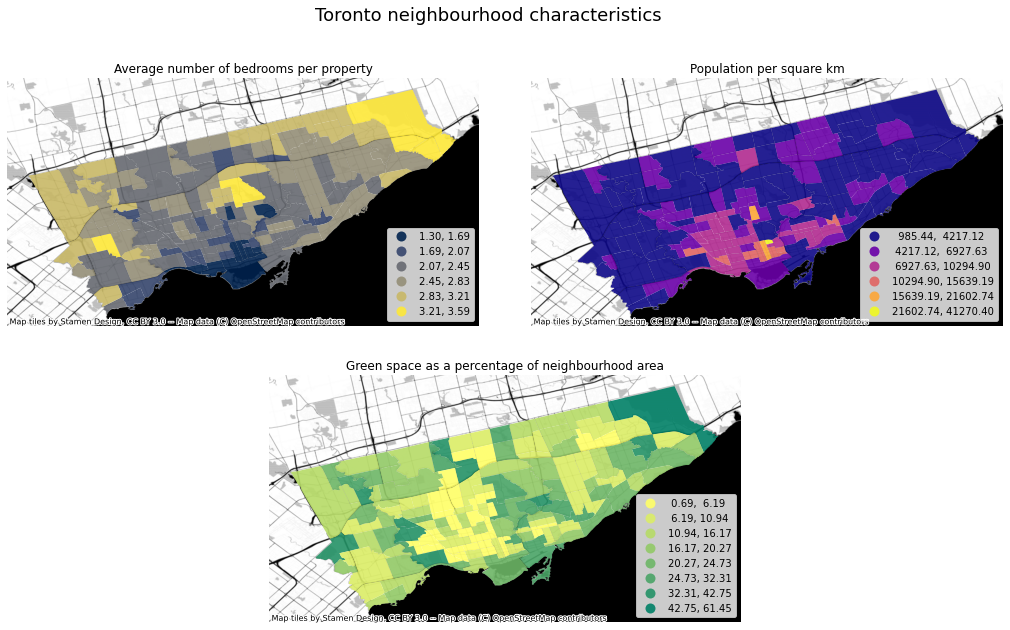

In [15]:
# Figure to display choropleths
fig = plt.figure(figsize=(18,10))

# Use gridspec to manage subplots
gs = gridspec.GridSpec(2, 4)

# Mean bedroom count choropleth
# Position upper left
ax1 = fig.add_subplot(gs[0, :2])

neis.plot(ax=ax1,
          column='meanBedroomCount',
          scheme='equal_interval', # Equal interval used due to linear bedroom count trend
          k=6,
          cmap='cividis',
          alpha=0.9,
          legend=True,
          legend_kwds={'loc':'lower right'}
         )
# Add title and remove axes
ax1.set_title("Average number of bedrooms per property")
ax1.set_axis_off()
# Add basemap for context
cx.add_basemap(ax1, 
               crs=neis.crs,
               source = cx.providers.Stamen.TonerBackground)

# Population density choropleth
# Position upper right
ax2 = fig.add_subplot(gs[0, 2:])

neis.plot(ax=ax2,
          column='popDensity_km-2',
          scheme='fisher_jenks', # Fisher Jenks used due to skewed distribution
          k=6,
          cmap='plasma',
          alpha=0.9,
          legend=True,
          legend_kwds={'loc': 'lower right'}
         )
# Add title and remove axes
ax2.set_title("Population per square km")
ax2.set_axis_off()
# Add basemap for context
cx.add_basemap(ax2, 
               crs=neis.crs,
               source = cx.providers.Stamen.TonerBackground)

# Green space percentage choropleth
# Position lower centre
ax3 = fig.add_subplot(gs[1, 1:3])

neis.plot(ax=ax3,
          column='greenSpacesArea%',
          scheme='fisher_jenks', # Fisher Jenks used due to skewed distribution
          k=8,
          cmap='summer_r',
          alpha=0.9,
          legend=True,
          legend_kwds={'loc':'lower right'}
         )
# Add title and remove axes
ax3.set_title("Green space as a percentage of neighbourhood area")
ax3.set_axis_off()
# Add basemap for context
cx.add_basemap(ax3, 
               crs=neis.crs,
               source = cx.providers.Stamen.TonerBackground)

# Add figure title
fig.suptitle('Toronto neighbourhood characteristics', fontsize=18)

plt.show()

The information from the socio-economic dataset visualised in the first two choropleths suggests the central neighbourhoods are characterised by densely populated areas of small property size. Moving outwards the neighbourhoods become more suburban, as population density drops and property size increases. As the neighbourhoods open up there is more room for parks and tree lined private gardens, as demonstrated by the third choropleth. Although green spaces offer many benefits to sustainable cities, more densely populated neighbourhoods also offer advantages such as more effective mass transit systems and more efficient property energy use [2].

### Spatial autocorrelation
The extent to which the choropleth trends hold across the city can be expressed through Moran plots. Due to the variation in neighbourhood shape and size, queen contiguity is used to best express the neighbourhoods' spatial relationships.

In [16]:
# Create spatial weights matrix from neighbourhood geometry based on queen contiguity
wQueen = weights.Queen.from_dataframe(neis)
# Row standardise spatial weight matrix
wQueen.transform = 'R'

In [17]:
def globalSpatialAutocorrelationPlotter(gdf, cols, swm):
    """
    Creates a figure containing 1 row of subplots
    Each subplot displays the moran plot for a variable in cols
    
    Parameters
    ----------
    gdf : geopandas geodataframe
        gdf containing columns of interest for gsa plots
        
    cols : list[string]
        list containing column names from gdf to plot
    
    swm : pysal spatial weights matrix
        spatial weights matrix based on gdf geometry
    """
    
    # Initialise empty geodataframe to store calculated variables
    gdfMoranPlot = gpd.GeoDataFrame()
    
    # Initialise empty dictionary to hold calculated moran's I for each variable
    miDict = {}
    
    # Create lists of new column names: standardised columns and spatial lag of standardised columns
    stdCols = [col + '_Standardised' for col in cols]
    slStdCols = [col + '_SpatialLag' for col in stdCols]       
    
    # Iterate over cols list
    for i, col in enumerate(cols):
        # Standardise col and add to moran plot gdf
        gdfMoranPlot[stdCols[i]] = (gdf[col]-gdf[col].mean())/gdf[col].std()
        # Calculate spatial lag of standardised col and add to moran plot gdf
        gdfMoranPlot[slStdCols[i]] = weights.lag_spatial(swm, gdfMoranPlot[stdCols[i]])
        # Calculate moran's I for standardised col and add to moran's I dictionary
        miDict[i] = str(esda.Moran(gdfMoranPlot[stdCols[i]], swm).I.round(3))
    
    # Figure to display moran plots
    # Share both axes across subplots to aid comparison
    fig, axs = plt.subplots(1, len(cols), figsize=(18, 6), sharex=True, sharey=True) 
    
    # Iterate over subplots array
    for i, ax in enumerate(axs):
        # Add moran plot from calculated columns stored in moran plot gdf
        sns.regplot(ax=ax, x=gdfMoranPlot[stdCols[i]], y=gdfMoranPlot[slStdCols[i]], ci=None)        
        # Add moran's I statistic in lower right quadrant
        ax.text(2, -1.5, 'Moran\'s I:\n' + miDict[i], fontsize=14)
        # Add lines at 0 on both axes to indicate mean
        ax.axvline(0, c='k', alpha=0.5)
        ax.axhline(0, c='k', alpha=0.5)
        # Add subplot title
        ax.set_title(cols[i])
        
    # Add figure title
    fig.suptitle('Global spatial autocorrelation of selected variables', fontsize=18)    
    return

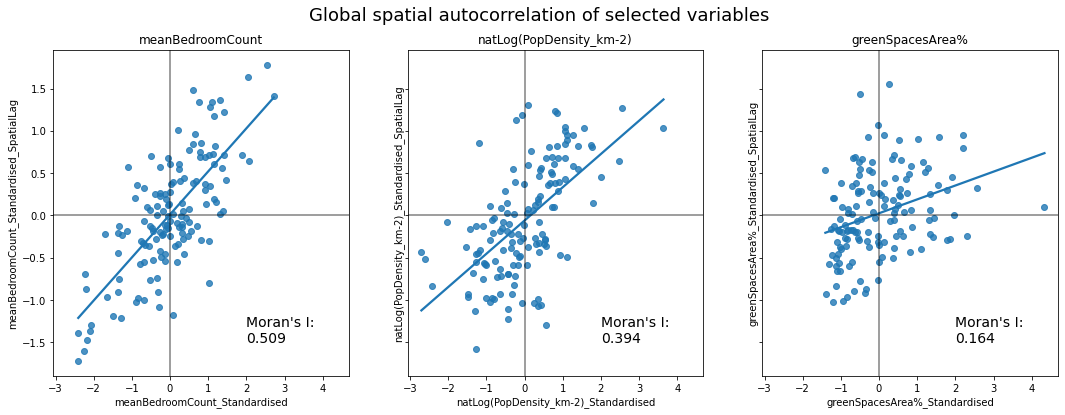

In [18]:
# Create list of columns to plot their global spatial autocorrelation
gsaCols = ['meanBedroomCount', 'natLog(PopDensity_km-2)', 'greenSpacesArea%']

# Call plotter function with main neighbourhoods gdf, columns to plot, and pre-defined spatial weights matrix
globalSpatialAutocorrelationPlotter(neis, gsaCols, wQueen)

The strong global spatial autocorrelation of mean bedroom count indicates regions within the city are broadly composed of similarly sized properties. The natural log of the population density was used due to its right skewed distribution. A lower Moran's I statistic indicates weaker autocorrelation, however similarity is still observed between adjacent neighbourhoods. Negative autocorrelation would have suggested regularly distributed green spaces, promoting equal accessibility. Although the autocorrelation is weaker, the positive trend indicates there are regions which share a lack of access to green spaces.

### Geodemographic classification
Having identified several regional characteristics, a k means based geodemographic classification will be performed to assess the strengths and weaknesses of neighbourhoods with regards to their sustainability credentials. It will also highlight which demographics, if any, are being most impacted by these features. Two methods will be implemented to evaluate the choice of k value: elbow method and Davies-Bouldin score [3].

In [19]:
def kMeansGeodemographicClassification(gdf, cols, kRange, kMap):
    """
    Creates a geodemographic classification using k means clustering algorithm
    Displays results of classification based on kMap clusters
    Plots 2 additional subplots showing inertia and davies-bouldin scores for values of k in kRange
    
    Parameters
    ----------
    gdf : geopandas geodataframe
        gdf containing columns of interest for k means clustering and geometry
        
    cols : list[string]
        list containing names of columns to be used for k means clustering
    
    kRange : range
        range of k values for which to evaluate inertia and davies-bouldin scores
        
    kMap : integer
        value of k used to create map
    
    Returns
    -------
    gdfClstr['kcls'] : pandas series
        series holding label for each row in gdf resulting from clustering for kMap clusters
    """
    
    # Initialise empty lists to store inertia and davies bouldin scores for each k
    inertias = []    
    dbs = []    
    # Create list of standardised column names
    stdCols = [col + 'Std' for col in cols]    
    
    # Create geodataframe to store standardised columns for clustering
    # Add original gdf geometry for plotting
    gdfClstr = gpd.GeoDataFrame({'geometry':gdf['geometry']})
    
    # Add standardised of columns of interest to clustering geodataframe
    for i, col in enumerate(cols):
        gdfClstr[stdCols[i]] = (gdf[col]-gdf[col].mean())/gdf[col].std()
    
    # Iterate over each value of k in range
    for k in kRange:                
        # Create k means clustering object for current k, random state for reproducibility
        kmeans = cluster.KMeans(n_clusters=k, random_state=321)
        # Identify cluster members using standardised columns of interest
        kcls = kmeans.fit(gdfClstr[stdCols])                
        # Add cluster labels to clustering geodataframe
        gdfClstr['kcls'] = kcls.labels_

        # Add inertia score to inertia score list directly
        inertias.append(kcls.inertia_)
        # Calculate davies bouldin score and add to list
        dbs.append(davies_bouldin_score(gdfClstr[stdCols], gdfClstr['kcls']))
        
        # If current k matches kMap, store current labels
        if k == kMap:
            kMapLabels = kcls.labels_.copy()

    # Overwrite clustering labels from final iteration with labels associated with kMap value of k, for plotting map
    gdfClstr['kcls'] = kMapLabels
    
    # Figure to display k means clustering results
    fig = plt.figure(figsize=(18,10))
    # Use gridspec to manage subplot positions
    gs = gridspec.GridSpec(3, 4)
            
    # Map geodemographic classification based on kMap value of k
    # Position upper centre
    ax1 = fig.add_subplot(gs[:2, :])
    
    gdfClstr.plot(ax=ax1,
                  column='kcls',
                  legend=True,
                  categorical=True,
                  cmap = 'Set1',
                  alpha=0.9,
                  legend_kwds={'loc':'lower right'}
                 )
    # Add title and remove axes
    ax1.set_title(f"Classification based on {kMap} clusters")
    ax1.set_axis_off()
    # Add basemap for context
    cx.add_basemap(ax1, 
                   crs=gdfClstr.crs,
                   source = cx.providers.Stamen.TonerBackground)
    
    # Plot inertia values for each k in kRange
    # Position lower left
    ax2 = fig.add_subplot(gs[2, :2])
    ax2.plot(kRange, inertias, '-o', color='b')
    # Add subplot title and x axis label
    ax2.set_title('Inertia')
    ax2.set_xlabel('k')
    # Add lines at kMap value
    ax2.axvline(kMap, c='k', alpha=0.5)
    ax2.axhline(inertias[kRange.index(kMap)], c='k', alpha=0.5)
    
    # Plot davies bouldin scores for each k in kRange
    # Position lower right
    ax3 = fig.add_subplot(gs[2, 2:])
    ax3.plot(kRange, dbs, '-o', color='b')
    # Add subplot title and x axis label
    ax3.set_title('Davies-bouldin score')
    ax3.set_xlabel('k')
    # Add lines at kMap value
    ax3.axvline(kMap, c='k', alpha=0.5)
    ax3.axhline(dbs[kRange.index(kMap)], c='k', alpha=0.5)
    
    # Add figure title
    fig.suptitle('K means clustering based geodemographic classification of Toronto neighbourhoods', fontsize=18)        
    
    # Return cluster labels from kMap clusters
    return gdfClstr['kcls']

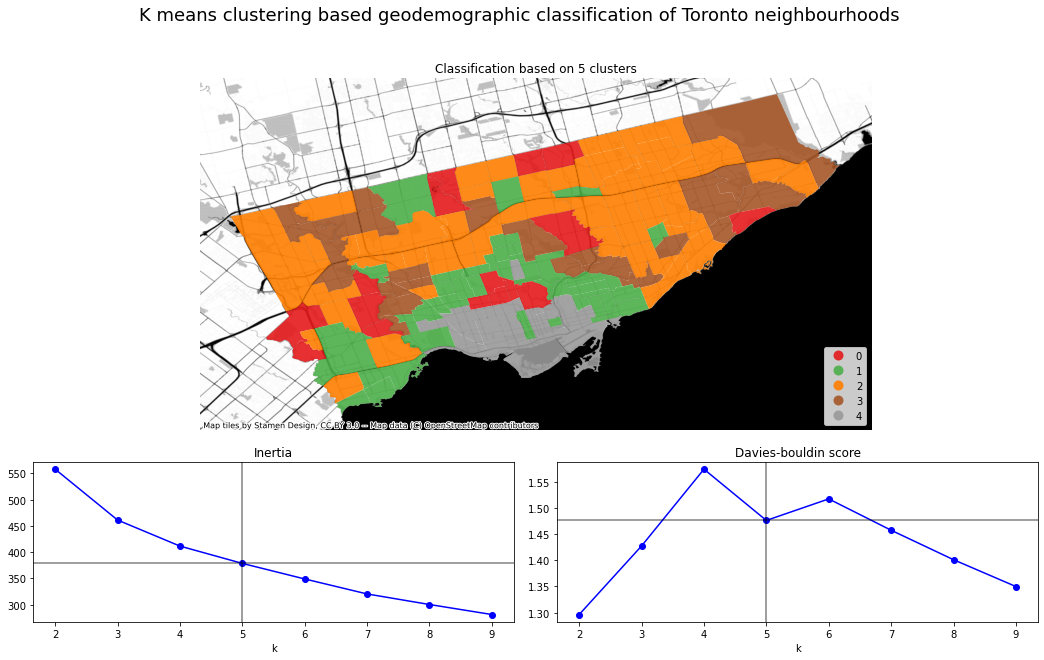

In [20]:
# Create list of columns to use for clustering
# Age demographic variables used: young people and retirement age; working age has the least variation
# It is also implied by the % rates of the other 2 so can be omitted to reduce total number of variables
clstrCols = ['greenSpacesArea%', 'activeTransportScore', 'Transit Score',
            'employmentRate%', 'youngPeopleRate%',  'retirementAgeRate%']

# Call geodemographic classification clustering function using:
# main neighbourhoods dataset; list of cols to use for clustering;
# range of k values to test; value of k for which to map results
# Add cluster labels resulting from mapping to main neighbourhood dataset
neis['kcls_5'] = kMeansGeodemographicClassification(neis, clstrCols, range(2,10), 5)

The number of variables used in the classification is limited to six to maintain meaningful distinction between clusters. The lack of a clear elbow in the inertia plot indicates no k value cleanly encapsulates the variables' distributions. To minimise the Davies-Bouldin score, the local minima of five clusters was chosen. Less than four clusters produces a simplistic classification and more than seven results in overly granular neighbourhood distinctions.

In [21]:
# Calculate mean of columns for each cluster to identify defining characteristics
kcl_5Summary = neis.groupby('kcls_5')[clstrCols].mean().round(1)
# Add a count column for number of neighbourhoods in each cluster
kcl_5Summary['count'] = neis.groupby('kcls_5')['_id'].count()
# Display summary table
kcl_5Summary

,greenSpacesArea%,activeTransportScore,Transit Score,employmentRate%,youngPeopleRate%,retirementAgeRate%,count
kcls_5,,,,,,,
0,18.6,57.4,72.9,94.0,24.1,23.4,16
1,12.3,72.5,83.0,88.9,27.3,13.5,36
2,12.0,51.0,71.4,86.1,28.2,17.9,42
3,29.0,49.7,73.2,80.6,32.2,14.1,25
4,10.0,86.5,96.2,89.3,21.0,12.9,21


This clustering demonstrates several defining characteristics. Cluster four is almost naturally regionalised. It benefits from high transit and active transport scores as might be expected from city centre neighbourhoods. The lack of green spaces could be hard to remedy in such a built up area but additional street level greenery could alleviate this.

Toronto city planners are aware of the importance of active transport through the findings of the 2011 Walkable City report [4]. Clusters two and three share many characteristics which city planners could address with these findings in mind. Higher proportions of young people live in these areas and it is arguably this group that could benefit most from improvements to the low active transport and middling transit scores found here. 

The defining difference between clusters two and three is cluster three's abundance of green space. The Black Creek neighbourhood is assigned to this cluster and it characterises some of the benefits already implemented by Toronto planners as detailed in the neighbourhood case study [4]. Following Toronto's recognition as a leading North American sustainable city, this analysis presents several areas where more could be done for the sake of both the local and global communities.

## Bibliography
[1] Arcadis. 2015. _Sustainable Cities Index 2015._  
https://sustainablestalbans.org/wp-content/uploads/2015/05/arcadis-sustainable-cities-index-report.pdf  
Last accessed on 14/12/21

[2] Farr, D.: Sustainable Urbanism. Urban Design with Nature. Farr Associates. Published by John Wiley & Sons, Inc., Hoboken,
New Jersey, 2008

[3] D. L. Davies and D. W. Bouldin, "A Cluster Separation Measure," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. PAMI-1, no. 2, pp. 224-227, April 1979, doi: 10.1109/TPAMI.1979.4766909.

[4] Toronto Public Health. April 2012. _The Walkable City: Neighbourhood Design and Preferences, Travel Choices and Health._  
https://www.toronto.ca/wp-content/uploads/2017/10/9617-TPH-walkable-city-report.pdf  
Last accessed on 14/12/21